<a href="https://colab.research.google.com/github/Eriol1052000/ETL/blob/main/Final_Project_Build_an_ML_Pipeline_for_Airfoil_noise_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Scenario
You are a data engineer at an aeronautics consulting company. Your company prides itself in being able to efficiently design airfoils for use in planes and sports cars. Data scientists in your office need to work with different algorithms and data in different formats. While they are good at Machine Learning, they count on you to be able to do ETL jobs and build ML pipelines. In this project you will use the modified version of the NASA Airfoil Self Noise dataset. You will clean this dataset, by dropping the duplicate rows, and removing the rows with null values. You will create an ML pipe line to create a model that will predict the SoundLevel based on all the other columns. You will evaluate the model and towards the end you will persist the model.

## Objectives


- Part 1 Perform ETL activity
  - Load a csv dataset
  - Remove duplicates if any
  - Drop rows with null values if any
  - Make transformations
  - Store the cleaned data in parquet format
- Part 2 Create a  Machine Learning Pipeline
  - Create a machine learning pipeline for prediction
- Part 3 Evaluate the Model
  - Evaluate the model using relevant metrics
- Part 4 Persist the Model
  - Save the model for future production use
  - Load and verify the stored model


## Datasets

 - The original dataset can be found here NASA airfoil self noise dataset. https://archive.ics.uci.edu/dataset/291/airfoil+self+noise

 - This dataset is licensed under a Creative Commons Attribution 4.0 International (CC BY 4.0) license.


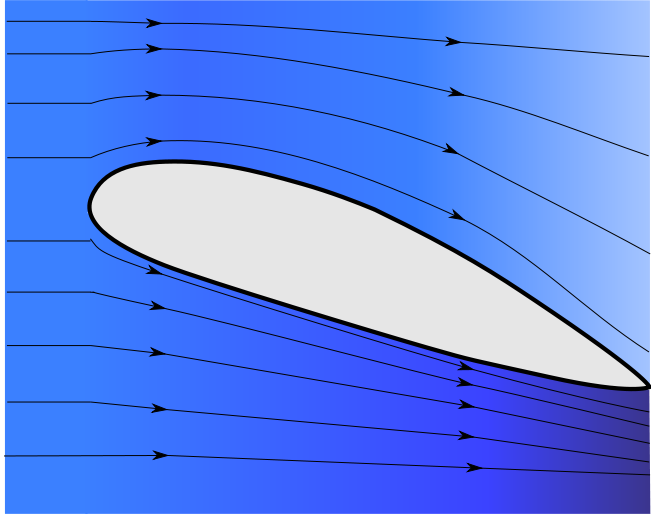

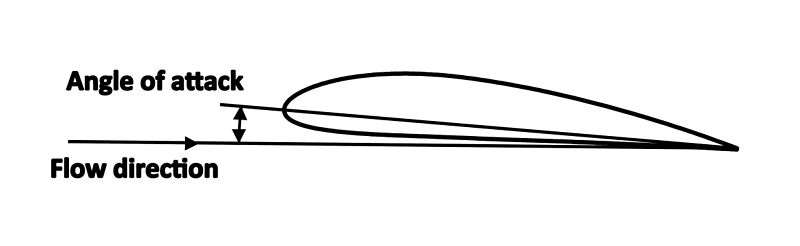

### Installing Required Libraries

In [ ]:
!pip install findspark
!pip install pyspark

In [ ]:
import findspark
findspark.init()

## Part 1 - Perform ETL activity


### Task 1 - Import required libraries


In [ ]:
#import functions/Classes for sparkml
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import SparkSession

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StringIndexer

# import functions/Classes for pipeline creation
from pyspark.ml import Pipeline

# import functions/Classes for metrics
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import numpy as np
import pandas as pd
from pyspark.sql import SparkSession

### Task 2 - Create a spark session


In [ ]:
#Create a SparkSession
spark = SparkSession.builder.appName("Final Project - Build an ML Pipeline for Airfoil noise prediction").getOrCreate()

### Task 3 - Load the csv file into a dataframe


In [ ]:
# Download the data file
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-BD0231EN-Coursera/datasets/NASA_airfoil_noise_raw.csv

In [ ]:
# using the spark.read.csv function we load the data into a dataframe.
# the header = True mentions that there is a header row in out csv file
# the inferSchema = True, tells spark to automatically find out the data types of the columns.

# Load mpg dataset
nasa_data = spark.read.csv('NASA_airfoil_noise_raw.csv', header=True, inferSchema=True)
print(nasa_data.printSchema())
print(nasa_data.show(5))

### Task 4 - Print top 5 rows of the dataset


In [ ]:
nasa_data.show(5)

### Task 6 - Print the total number of rows in the dataset


In [ ]:
nasa_data.count()

### Task 7 - Drop all the duplicate rows from the dataset


In [ ]:
nasa_data.exceptAll(nasa_data.dropDuplicates()).count()

In [ ]:
df = nasa_data.dropDuplicates()

### Task 8 - Print the total number of rows in the dataset


In [ ]:
df.count()

### Task 9 - Drop all the rows that contain null values from the dataset


In [ ]:
df1 = df.dropna()

### Task 10 - Print the total number of rows in the dataset


In [ ]:
df1.count()

### Task 11 - Rename the column "SoundLevel" to "SoundLevelDecibels"Drop


In [ ]:
df2 =df1.withColumnRenamed("SoundLevel","SoundLevelDecibels")
df2.show(5)

### Task 12 - Save the dataframe in parquet formant, name the file as "NASA_airfoil_noise_cleaned.parquet"


In [ ]:
df2.write.parquet("NASA_airfoil_noise_cleaned.parquet")

#### Part 1 - Evaluation


In [ ]:
import os

print("NASA_airfoil_noise_cleaned.parquet exists :", os.path.isdir("NASA_airfoil_noise_cleaned.parquet"))

## Part - 2 Create a  Machine Learning Pipeline


### Task 1 - Load data from "NASA_airfoil_noise_cleaned.parquet" into a dataframe


In [ ]:
df3 = spark.read.parquet('NASA_airfoil_noise_cleaned.parquet')
df3.show()

### Task 2 - Print the total number of rows in the dataset


In [ ]:
df3.count()

### Task 3 - Define the VectorAssembler pipeline stage


In [ ]:
# Stage 1 - assemble the input columns into a single vector
vectorAssembler = VectorAssembler(inputCols=["Frequency", "AngleOfAttack", "ChordLength","FreeStreamVelocity","SuctionSideDisplacement"], outputCol="features")

### Task 4 - Define the StandardScaler pipeline stage


In [ ]:
# Stage 2 - scale the features using standard scaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

### Task 5 - Define the StandardScaler pipeline stage


In [ ]:
# Stage 3 - create a linear regression instance
lr = LinearRegression(featuresCol="scaledFeatures", labelCol="SoundLevelDecibels")

### Task 6 - Build the pipeline


In [ ]:
# Build the pipeline
# All the stages of the pipeline are mentioned in the order of execution.
pipeline = Pipeline(stages=[vectorAssembler, scaler, lr])

### Task 7 - Split the data


In [ ]:
# Split the data into training and testing sets
(training_data,testing_data) = df3.randomSplit([0.7,0.3],seed=42)

### Task 8 - Fit the pipeline


In [ ]:
# Fit the pipeline to the training data
model = pipeline.fit(training_data)

## Part 3 - Evaluate the Model


### Task 1 - Predict using the model


In [ ]:
# Make predictions on the testing data
predictions = model.transform(testing_data)
predictions.show()

### Task 2 - Print the MSE, R2, MAE


In [ ]:
evaluator = RegressionEvaluator(labelCol="SoundLevelDecibels", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("R Squared =", r2)


evaluator = RegressionEvaluator(labelCol="SoundLevelDecibels", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(predictions)
print("MAE =", mae)


evaluator = RegressionEvaluator(labelCol="SoundLevelDecibels", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("RMSE =", rmse)

## Part 4 - Persist the Model


In [ ]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Create a folder in the root directory
!mkdir -p "/content/drive/My Drive/PORFOLIO"

### Task 1 - Save the model to the path "Final_Project"


In [ ]:
model.write().save("/content/drive/My Drive/PORFOLIO/Final_Project")

### Task 2 - Load the model from the path "Final_Project"


In [ ]:
from pyspark.ml.pipeline import PipelineModel
# Load the pipeline model you have created in the previous step
loadedPipelineModel = PipelineModel.load("/content/drive/My Drive/PORFOLIO/Final_Project")

### Task 3 - Make predictions using the loaded model on the testdata


In [ ]:
predictions = loadedPipelineModel.transform(testing_data)

### Task 4 - Show the predictions


In [ ]:
predictions.select("SoundLevelDecibels","prediction").show()

### Task 5 - Stop Spark Session


In [ ]:
spark.stop()